In [85]:
#run in python 3.10.7 on windows
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

auckland_rain = pd.read_csv('../data/auckland_rain_temp_statsNZ.csv', parse_dates=['date'])
auckland_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          20819 non-null  datetime64[ns]
 1   rainfall(mm)  20819 non-null  float64       
 2   tavg          20819 non-null  float64       
 3   tmax          20819 non-null  float64       
 4   tmin          20819 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 813.4 KB


In [86]:
auckland_rain.head()

,date,rainfall(mm),tavg,tmax,tmin
0,1966-01-01,0.0,18.0,22.2,13.9
1,1966-01-02,26.2,20.5,23.9,17.1
2,1966-01-03,0.0,20.3,23.5,17.1
3,1966-01-04,0.0,20.3,24.4,16.2
4,1966-01-05,1.3,20.6,23.4,17.8


In [87]:
# Summary Statistics
print(auckland_rain.describe())

                      date  rainfall(mm)          tavg          tmax  \
count                20819  20819.000000  20819.000000  20819.000000   
mean   1994-07-02 00:00:00      3.017811     15.463764     19.009117   
min    1966-01-01 00:00:00      0.000000      5.000000      8.100000   
25%    1980-04-01 12:00:00      0.000000     12.600000     15.900000   
50%    1994-07-02 00:00:00      0.000000     15.400000     18.700000   
75%    2008-09-30 12:00:00      2.600000     18.400000     22.100000   
max    2022-12-31 00:00:00    161.800000     25.600000     30.500000   
std                    NaN      7.304329      3.750680      3.876209   

               tmin  
count  20819.000000  
mean      11.918176  
min       -0.300000  
25%        9.200000  
50%       12.100000  
75%       15.000000  
max       22.900000  
std        4.030235  


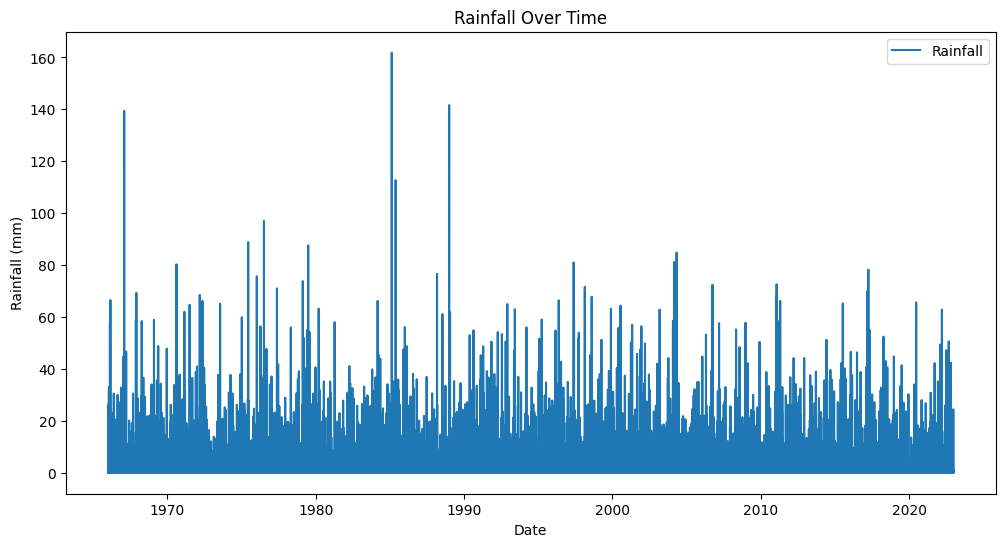

In [88]:
# Data Visualization

# Time series plot of rainfall
plt.figure(figsize=(12, 6))
plt.plot(auckland_rain['date'], auckland_rain['rainfall(mm)'], label='Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Over Time')
plt.legend()
plt.show()

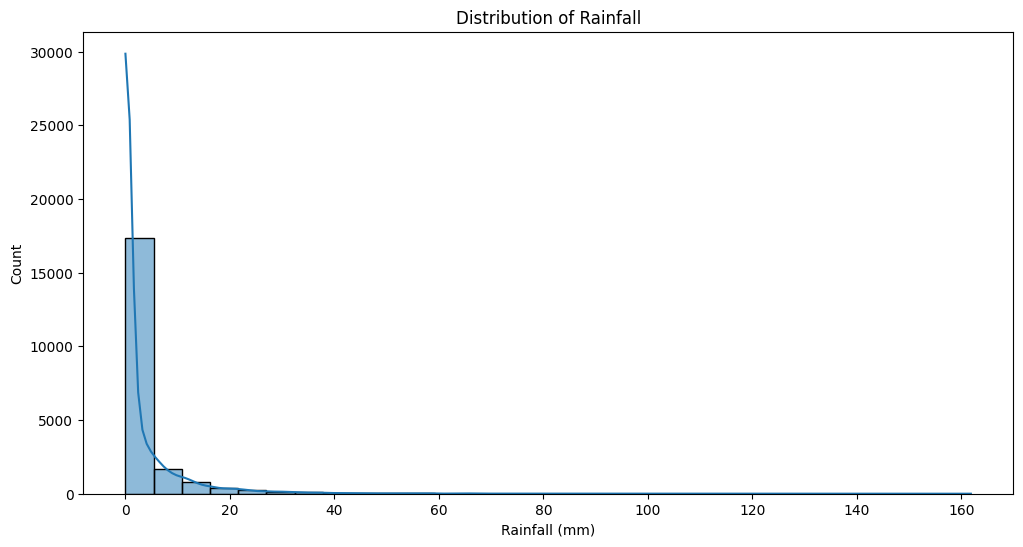

In [89]:
# Histograms
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(data=auckland_rain, x='rainfall(mm)', bins=30, kde=True)
plt.xlabel('Rainfall (mm)')
plt.title('Distribution of Rainfall')
plt.show()

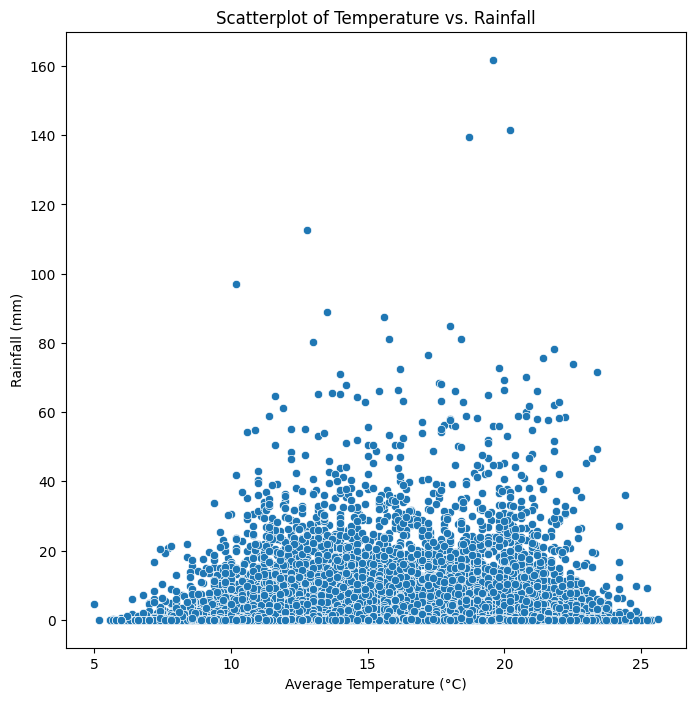

In [90]:
# Scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=auckland_rain, x='tavg', y='rainfall(mm)')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.title('Scatterplot of Temperature vs. Rainfall')
plt.show()

In [91]:
# Handling Missing Data
missing_data = auckland_rain.isnull().sum()
print(missing_data)

date            0
rainfall(mm)    0
tavg            0
tmax            0
tmin            0
dtype: int64


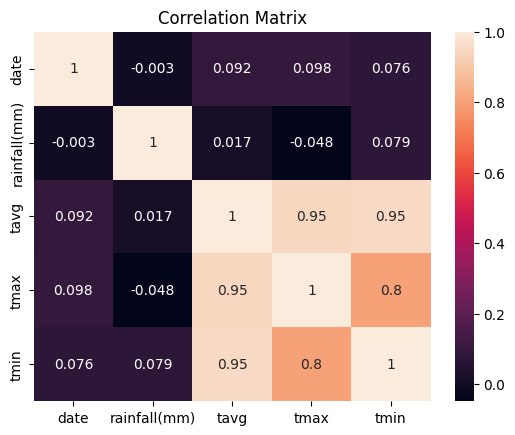

In [92]:
# Correlation Analysis
correlation_matrix = auckland_rain.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [93]:
# Create lag features for prevous 7 days of rainfall and temperature
lag_days = 7
for i in range(1, lag_days + 1):
    for column in ['rainfall(mm)', 'tavg', 'tmax', 'tmin']:
        auckland_rain[f'lag_{column}_{i}'] = auckland_rain[column].shift(i)

# Drop rows with NaN values due to lag features
auckland_rain.dropna(inplace=True)

auckland_rain.head(5)

,date,rainfall(mm),tavg,tmax,tmin,lag_rainfall(mm)_1,lag_tavg_1,lag_tmax_1,lag_tmin_1,lag_rainfall(mm)_2,...,lag_tmax_5,lag_tmin_5,lag_rainfall(mm)_6,lag_tavg_6,lag_tmax_6,lag_tmin_6,lag_rainfall(mm)_7,lag_tavg_7,lag_tmax_7,lag_tmin_7
7,1966-01-08,1.3,19.7,22.1,17.3,5.1,20.0,23.7,16.3,8.9,...,23.5,17.1,26.2,20.5,23.9,17.1,0.0,18.0,22.2,13.9
8,1966-01-09,2.5,17.8,19.7,15.9,1.3,19.7,22.1,17.3,5.1,...,24.4,16.2,0.0,20.3,23.5,17.1,26.2,20.5,23.9,17.1
9,1966-01-10,0.0,16.2,18.0,14.4,2.5,17.8,19.7,15.9,1.3,...,23.4,17.8,0.0,20.3,24.4,16.2,0.0,20.3,23.5,17.1
10,1966-01-11,0.5,16.8,19.3,14.4,0.0,16.2,18.0,14.4,2.5,...,23.4,18.6,1.3,20.6,23.4,17.8,0.0,20.3,24.4,16.2
11,1966-01-12,0.5,18.0,20.5,15.6,0.5,16.8,19.3,14.4,0.0,...,23.7,16.3,8.9,21.0,23.4,18.6,1.3,20.6,23.4,17.8


In [94]:
print(auckland_rain.columns)


Index(['date', 'rainfall(mm)', 'tavg', 'tmax', 'tmin', 'lag_rainfall(mm)_1',
       'lag_tavg_1', 'lag_tmax_1', 'lag_tmin_1', 'lag_rainfall(mm)_2',
       'lag_tavg_2', 'lag_tmax_2', 'lag_tmin_2', 'lag_rainfall(mm)_3',
       'lag_tavg_3', 'lag_tmax_3', 'lag_tmin_3', 'lag_rainfall(mm)_4',
       'lag_tavg_4', 'lag_tmax_4', 'lag_tmin_4', 'lag_rainfall(mm)_5',
       'lag_tavg_5', 'lag_tmax_5', 'lag_tmin_5', 'lag_rainfall(mm)_6',
       'lag_tavg_6', 'lag_tmax_6', 'lag_tmin_6', 'lag_rainfall(mm)_7',
       'lag_tavg_7', 'lag_tmax_7', 'lag_tmin_7'],
      dtype='object')


# LSTM

In [95]:
# Standardize Data
target_scaler = StandardScaler()

# Reshape the data for LSTM
sequence_length = 30

X_sequences = []
y_target = []

for i in range(len(auckland_rain) - sequence_length):
    X_sequences.append(auckland_rain.iloc[i:i+sequence_length, 2:].values)  # Select columns with lag features
    y_target.append(auckland_rain.iloc[i + sequence_length]['rainfall(mm)'])  # Predict lag_rainfall_1


X_sequences = np.array(X_sequences)
y_target = np.array(y_target)

In [96]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_target, test_size=0.2, random_state=42)

In [97]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [98]:
# Train the LSTM Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/50
520/520 [==============================] - 7s 11ms/step - loss: 71.2212 - val_loss: 49.6582
Epoch 2/50
520/520 [==============================] - 6s 11ms/step - loss: 55.9001 - val_loss: 47.6655
Epoch 3/50
520/520 [==============================] - 6s 11ms/step - loss: 55.3526 - val_loss: 46.5481
Epoch 4/50
520/520 [==============================] - 6s 11ms/step - loss: 54.9286 - val_loss: 47.7524
Epoch 5/50
520/520 [==============================] - 6s 11ms/step - loss: 54.8087 - val_loss: 46.4577
Epoch 6/50
520/520 [==============================] - 6s 11ms/step - loss: 54.4291 - val_loss: 46.3235
Epoch 7/50
520/520 [==============================] - 6s 11ms/step - loss: 54.5558 - val_loss: 46.4546
Epoch 8/50
520/520 [==============================] - 6s 11ms/step - loss: 54.3075 - val_loss: 46.5186
Epoch 9/50
520/520 [==============================] - 6s 11ms/step - loss: 54.5371 - val_loss: 46.6357
Epoch 10/50
520/520 [==============================] - 6s 11ms/step - los

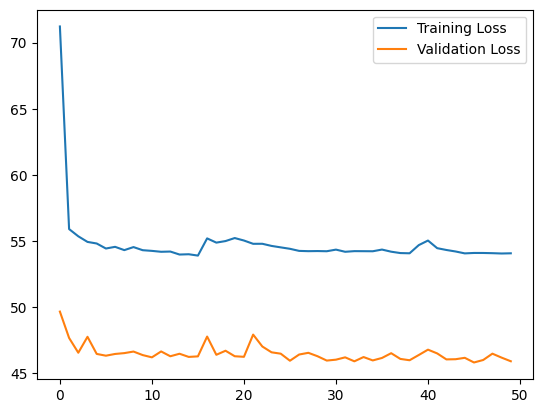

In [99]:
# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [100]:
# Make Predictions
y_pred_scaled = model.predict(X_test)

130/130 [==============================] - 1s 5ms/step


In [101]:
# Inverse transform the predictions for the target variable
y_pred_original_scale = target_scaler.inverse_transform(y_pred_scaled)

# Reshape y_test
y_test = y_test.reshape(-1, 1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_original_scale))
print("Root Mean Squared Error (RMSE):", rmse)

# Combine the 'date' column with the predictions
y_pred_original_scale = pd.DataFrame({'date': auckland_rain.iloc[-len(y_test):]['date'].values, 'rainfall(mm)': y_pred_original_scale.flatten()})


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
print(y_pred_scaled.shape)  # Check the shape of y_pred_scaled
print(y_test.shape)  # Check the shape of y_test

(4157, 1)
(4157, 1)


In [102]:
# Calculate monthly median rainfall
monthly_median_rainfall = auckland_rain.groupby(auckland_rain['date'].dt.month)['rainfall(mm)'].median()

# Calculate the percentage of actual rainfall compared to the monthly median
auckland_rain['rainfall_percentage'] = (auckland_rain['rainfall(mm)'] / monthly_median_rainfall[auckland_rain['date'].dt.month].values) * 100

# Create a function to categorize the weather conditions
def categorize_rainfall_condition(percentage):
    if percentage > 200:
        return "Very wet"
    elif percentage > 110:
        return "Moderately wet"
    elif percentage > 90:
        return "Near normal"
    elif percentage > 50:
        return "Moderately dry"
    else:
        return "Very dry"

# Apply the categorization function to create a new column with the weather condition
auckland_rain['weather_condition'] = auckland_rain['rainfall_percentage'].apply(categorize_rainfall_condition)

# Print the resulting dataframe with weather conditions
print(auckland_rain[['date', 'rainfall(mm)', 'rainfall_percentage', 'weather_condition']])



            date  rainfall(mm)  rainfall_percentage weather_condition
7     1966-01-08           1.3                  inf          Very wet
8     1966-01-09           2.5                  inf          Very wet
9     1966-01-10           0.0                  NaN          Very dry
10    1966-01-11           0.5                  inf          Very wet
11    1966-01-12           0.5                  inf          Very wet
...          ...           ...                  ...               ...
20814 2022-12-27           0.0                  NaN          Very dry
20815 2022-12-28           0.0                  NaN          Very dry
20816 2022-12-29           0.0                  NaN          Very dry
20817 2022-12-30           0.0                  NaN          Very dry
20818 2022-12-31           0.8                  inf          Very wet

[20812 rows x 4 columns]
